Variable	Definition
survival	Survival	     0 = No, 1 = Yes   
pclass	    Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  
Sex  	    Sex	  
Age	        Age in years	  
sibsp	    # of siblings / spouses aboard the Titanic	  
parch	    # of parents / children aboard the Titanic	  
ticket	    Ticket number	  
fare	    Passenger fare 

# Using the Titanic Dataset to Learn Data Science

In [1]:
# import 
# algebra tools
import math
import numpy as np 

# data processing tools
import pandas as pd 
import re

# data visualization tools
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# algorithms building tools
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier

In [2]:
# upload train and test files
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
data = [train_df, test_df]

## view our datasets

In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# missing data calculator : train_df
null_total = train_df.isnull().sum()
null_percent = (train_df.isnull().sum()/train_df.isnull().count())*100
null_percent_r = (round(null_percent, 1))
null_summary = pd.concat([null_total, null_percent_r ], axis=1, keys=['Total', '%'])
null_summary.head(20)

,Total,%
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,177,19.9
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0


In [6]:
# missing data calculator : test_df
test_df_null_total = test_df.isnull().sum()
test_df_null_percent = (test_df.isnull().sum()/test_df.isnull().count())*100
test_df_null_percent_r =(round(test_df_null_percent, 1))
test_df_null_summary = pd.concat([test_df_null_total, test_df_null_percent_r ], axis=1, keys=['Total', '%'])
test_df_null_summary.head(20)

,Total,%
PassengerId,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,86,20.6
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,1,0.2
Cabin,327,78.2


## looks like we have a little bit of preprocessing to do, before we build our model.

## missing Embarked: 2 Cases

Looks like we only have 2 missing values.

In [7]:
#findout where the 2 missing embarked values are
np.where(train_df['Embarked'].isnull())

(array([ 61, 829], dtype=int64),)

In [8]:
train_df.iloc[[61,829]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We found them, two women paid the same fare, same class and share the same ticket number. Maybe friends (or coworkers?) traveling together. We can try using the fare cost and ticket class to estimate their embarkment location.

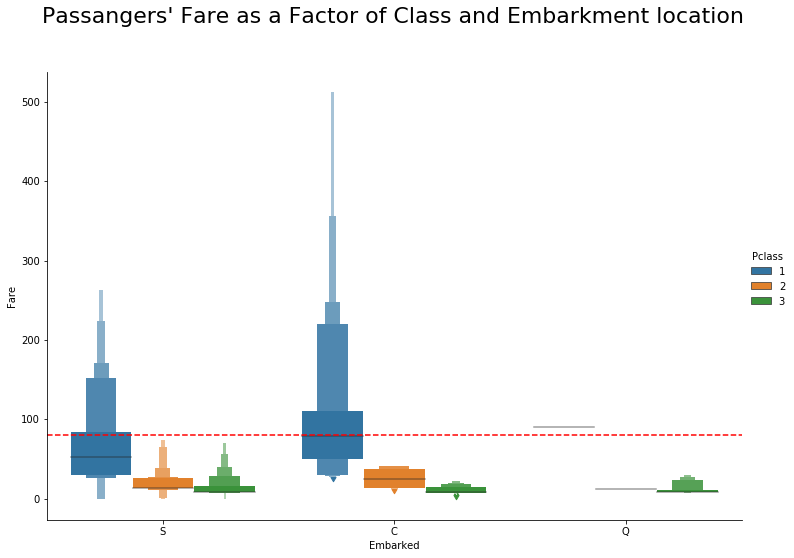

In [9]:
#construct mini dataframe, dropna to avoid errors
embarked_df = train_df.drop([61,829], axis=0)

#visualize: Embarkment location vs. Pclass and Fare
sns.catplot(x='Embarked', y='Fare', hue='Pclass', kind='boxen', data= train_df, height=7, aspect=1.5)
plt.axhline(y=80, color='r', ls='--') #dotted line at $80 far price
plt.suptitle('Passangers\' Fare as a Factor of Class and Embarkment location', fontsize=22, y = 1.1)
plt.show()

Looks like our passangers in question paid the mediam fare of first class passangers who embarked in 'C'.

In [10]:
#based on the box catplot, let's replace missing Embarked values
train_df.loc[[61,829],'Embarked']= 'C'
train_df.iloc[[61,829]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,C
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,C


## missing Fare: 1 Case

In [11]:
#findout where the 1 missing Fare value is
np.where(test_df['Fare'].isnull())

(array([152], dtype=int64),)

In [12]:
test_df.iloc[[152]]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [13]:
# using the previous method to calculate Embarked from Fare and Pclass,
# we can calculate (estimate) the fare that mister thomas paid

test_df.groupby(['Pclass', 'Embarked']).median()

PassengerId   Age  SibSp  Parch      Fare
Pclass Embarked                                           
1      C              1091.0  43.0    0.0    0.0  75.24585
       Q              1303.0  37.0    1.0    0.0  90.00000
       S              1095.0  42.0    0.0    0.0  51.67085
2      C              1156.0  27.0    0.0    0.0  15.04580
       Q               942.0  61.0    0.0    0.0  11.52915
       S              1131.5  26.0    0.0    0.0  21.00000
3      C              1065.0  21.0    0.0    0.0   7.22920
       Q              1092.0  24.0    0.0    0.0   7.75000
       S              1092.0  24.0    0.0    0.0   8.05000

In [14]:
# there we go, the median value for someone who embarked in S, with a Pclass of 3 is 8.05000
test_df.loc[[152],'Fare']= 8.05000
test_df.iloc[[152]]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,8.05,NaN,S


## Cabin --> Deck

In [15]:
#fillna in'Cabin' with U0 and replace with 'Deck' 
# import regular expressions
import re

#dictionaries will make our maping easier
deck_dict = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

# use a for loop to make changes to both train_df and test_df
data = [train_df, test_df]
for variable in data:
    #fill missing values in 'Cabin' with U0, save over 'Cabin'
    variable['Cabin'] = variable['Cabin'].fillna("U0")
    #create new column 'Deck' map first leter in 'Cabin' to 'Deck'
    variable['Deck'] = variable['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    # use dictionary 'deck' to change ABC-G to 123-8
    variable['Deck'] = variable['Deck'].map(deck_dict).fillna(0).astype(int)
    #drop 'Cabin' 
    variable.drop('Cabin', axis=1, inplace=True)

In [16]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,8


## Age

Looks like we have a lot of missing age values.

In [17]:
#fillna in 'Age' with random numbers around the mean age
#compute 'Age' mean and stdev
age_mean = train_df['Age'].mean()
age_stdev = train_df['Age'].std()
age_null_sum = train_df['Age'].isnull().sum()

#compute random numbers 1 stdev around the mean, size = age_null_sum
random_age_numbers = np.random.randint(age_mean - age_stdev, age_mean + age_stdev, size = age_null_sum)

#fill missing values in 'Age' with random ages
train_age_random_slice = train_df["Age"].copy()
train_age_random_slice[np.isnan(train_age_random_slice)] = random_age_numbers

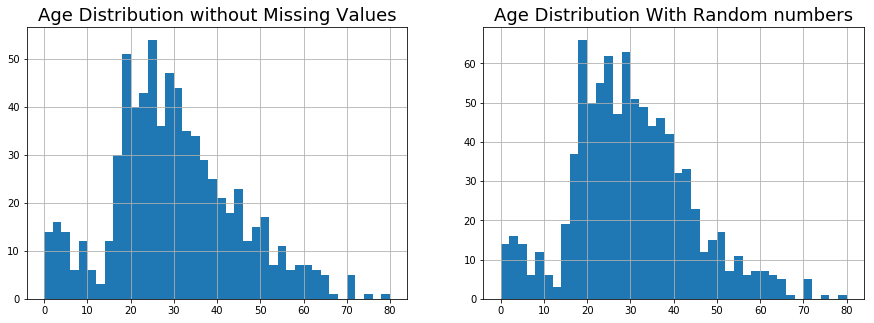

In [18]:
#plot 'Age' and age_slice histograms to visually ensuare rand_age didnt change data identity very much
fig, (axis1,axis2) = plt.subplots(1,2, figsize=(15,5))
axis1.set_title('Age Distribution without Missing Values', fontsize=18, y = 1.0)
axis2.set_title('Age Distribution With Random numbers', fontsize=18, y = 1.0)

train_df['Age'].dropna().astype(int).hist(bins=40, ax=axis1)
train_age_random_slice.astype(int).hist(bins=40, ax=axis2)

plt.show()

##### While this looks tempting, I have reservations about using this aproach.
##### Using a random number generator will  assign age values to passagers illogically, which will most likely alter/ erase age-survivablity patterns. Additionally, the fact that some passangers have missing values while others do not might be valuable information in itself.

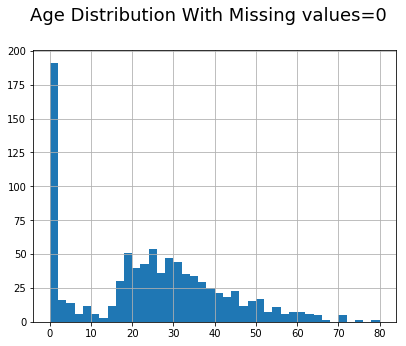

In [19]:
# simpler way, all missing age values= 0
# even though this looks odd, this avoids confusing our model with randomly generated numbers
train_age_zero_slice = train_df["Age"].copy()
rr= train_age_zero_slice.fillna(value=0).astype(int)

fig, axis3 = plt.subplots(1,1, figsize=(6.5,5))
rr.hist(bins=40)
plt.suptitle('Age Distribution With Missing values=0', fontsize=18, y = 1.0)

plt.show()

In [20]:
for variable in data:
    #fill missing values in 'Cabin' with U0, save over 'Cabin'
    variable['Age'] = variable['Age'].fillna(value=0).astype(int)

In [21]:
train_df['Age'].isnull().sum()

0

In [22]:
test_df['Age'].isnull().sum()

0

In [23]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,8


## Name --> Title

when looking at the names column, I notice that within each passanger name there is a title included. A person's title could give us information on their: socioeconomic status, level of education, age and gender. Although we already have some of that information already this might still be useful in someway. We should definitely pull the titles out and use them for our models later on.

In [ ]:
#compile passangers' titles from 'Name' and put that information in new column 'Title' 
#this could have been much shorter using regx but i wanted to see if it could be done this way
#the fact that the titles are always between a ", " and a ". " makes this simple
new_col = train_df["Name"].str.split(", ", n = 3, expand = True)
new_col2 = new_col[1].str.split(". ", n = 3, expand = True)
train_df["Title"]= new_col2[0]

In [ ]:
#do the same manipulation to the test_df to avoid errors later on
new_col3 = test_df["Name"].str.split(", ", n = 3, expand = True)
new_col4 = new_col3[1].str.split(". ", n = 3, expand = True)
test_df["Title"]= new_col4[0]

In [ ]:
train_df.groupby(['Sex', 'Title']).size().unstack(fill_value=0)

Title,Capt,Col,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,th
Sex,,,,,,,,,,,,,,,,,
female,0,0,0,1,0,1,0,0,182,2,1,0,125,1,0,0,1
male,1,2,1,6,1,0,2,40,0,0,0,517,0,0,6,1,0


In [ ]:
test_df.groupby(['Sex', 'Title']).size().unstack(fill_value=0)

Title,Col,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
Sex,,,,,,,,,
female,0,1,0,0,78,0,72,1,0
male,2,0,1,21,0,240,0,0,2


Looks like our manipulation worked, but maybe we dont need to keep around titles with less than 5 people. As well as, match french titles with their english translation. 

In [ ]:
#replace less common names to more common ones
##previously tried using a for loop with .map()  to a dictionary like I did in the capin situation but with no luck. 


train_df.replace(['Capt', 'Col', 'Don', 'Jonkheer', 'Lady', 
                        'Major', 'Mlle', 'Mme', 'Ms', 'Sir', 'th', 'Dona'], 
                       ['Mr', 'Mr', 'Mr', 'Mr', 'Mrs',
                        'Mr', 'Miss', 'Mrs', 'Miss', 'Mr', 'Miss', 'Mrs'], inplace= True)

#do the same manipulation to the testing data
test_df.replace(['Capt', 'Col', 'Don', 'Jonkheer', 'Lady', 
                        'Major', 'Mlle', 'Mme', 'Ms', 'Sir', 'th', 'Dona'], 
                       ['Mr', 'Mr', 'Mr', 'Mr', 'Mrs',
                        'Mr', 'Miss', 'Mrs', 'Miss', 'Mr', 'Miss', 'Mrs'], inplace= True)

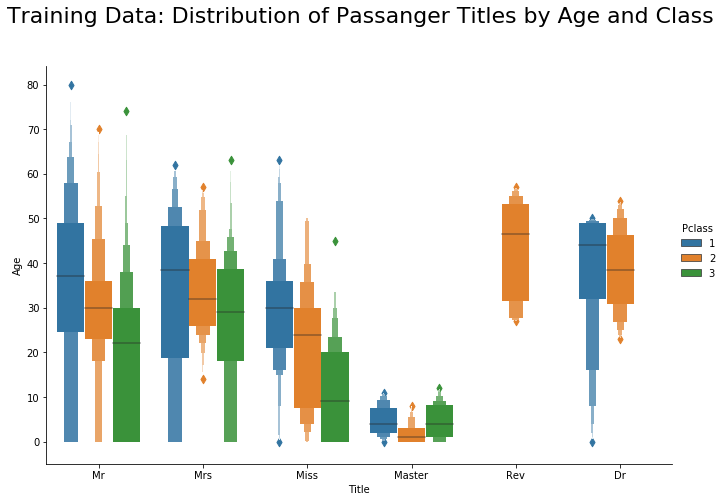

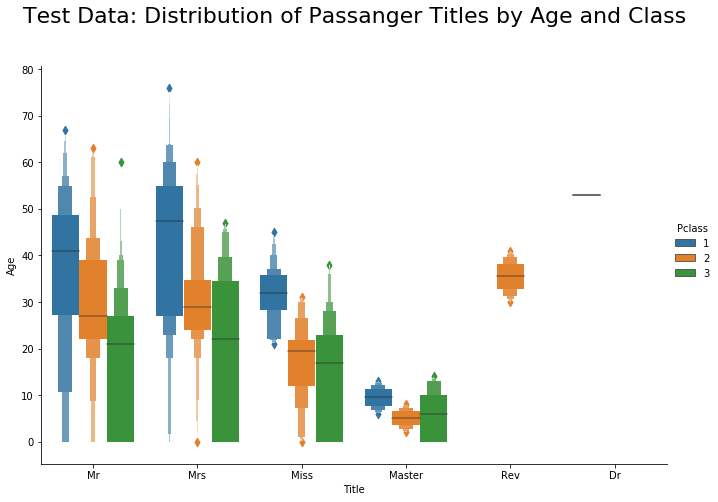

In [ ]:
#Lets visulaize what we did
sns.catplot(x='Title', y='Age', hue='Pclass', kind='boxen', data= train_df, height=6.3, aspect=1.5)
plt.suptitle("Training Data: Distribution of Passanger Titles by Age and Class", fontsize=22, y = 1.1)
plt.show()

sns.catplot(x='Title', y='Age', hue='Pclass', kind='boxen', data= test_df, height=6.3, aspect=1.5)
plt.suptitle("Test Data: Distribution of Passanger Titles by Age and Class", fontsize=22, y = 1.1)
plt.show()

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,8,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,3,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,8,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,3,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,8,Mr


In [ ]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title
0,892,3,"Kelly, Mr. James",male,34,0,0,330911,7.8292,Q,8,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47,1,0,363272,7.0000,S,8,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62,0,0,240276,9.6875,Q,8,Mr
3,895,3,"Wirz, Mr. Albert",male,27,0,0,315154,8.6625,S,8,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22,1,1,3101298,12.2875,S,8,Mrs


##  Parch and SibSp --> FamilySize

In [ ]:
#because family can get complicated, lets create a new df for this
fam_df = train_df.loc[:,["Parch", "SibSp", "Survived"]]
fam_df["FamSize"]= train_df["Parch"] + train_df["SibSp"] + 1  # +1 for 'self'
fam_df = fam_df.drop(['Parch', 'SibSp'],axis=1)

#count plot
sns.catplot(x='FamSize', kind='count', data= fam_df, height=5, aspect=1.5, palette="Purples_d")
plt.suptitle('Family Size Distribution', fontsize=20, y = 1.0)
plt.show()

In [ ]:
#calculate survival rate by family size
survival_by_famsize_df = fam_df.groupby(['FamSize', 'Survived']).size().unstack(fill_value=0)
survival_by_famsize_df['Total']= fam_df.groupby(['FamSize']).size()
survival_by_famsize_df['Family Size']= survival_by_famsize_df.index.tolist()
survival_by_famsize_df['Survival Rate (%)']= ((survival_by_famsize_df.iloc[:,1]/survival_by_famsize_df['Total'])*100).round(1)
survival_by_famsize_df.set_index('Family Size')

In [ ]:
#let's visualize the family situation
sns.catplot(x='Family Size', y='Total',kind='bar', data= survival_by_famsize_df, height=5, aspect=1.5, palette="Purples_d")
plt.suptitle('Family Size Distribution', fontsize=20, y = 1.0)
plt.show()

sns.catplot(x='Family Size', y='Survival Rate (%)', kind='bar', data= survival_by_famsize_df,
            height=5, aspect=1.5,  palette="Purples_d")
plt.suptitle('Survival Rate By Family Size', fontsize=20, y = 1.1)
plt.show()


looks like having a family of 2-4 is ideal for survival

In [ ]:
#okay it worked, let's use a for loop to make changes to both train_df and test_df
data = [train_df, test_df]

for variable in data:
    variable["FamSize"]= variable["Parch"] + variable["SibSp"] + 1
    #will not drop 'Parch' and 'SibSp' because i think they might still be useful seperatly
    
train_df.head()

In [ ]:
#calculate survival rate by gender
sex_df = train_df.loc[:,["Sex", "Survived"]]
survival_by_sex_df = sex_df.groupby(['Sex', 'Survived']).size().unstack(fill_value=0)
survival_by_sex_df['Total'] = survival_by_sex_df[0]+survival_by_sex_df[1]
survival_by_sex_df

In [ ]:
#lets visualize this data using a pie chart

#calculate appropriate radii for pie chart so the area's correlate with total number of men/women
import math
pi = math.pi
#Area=pi*(r**2)
pie_Radius = (0.12*(survival_by_sex_df['Total']/pi)**(1/2)).round(1)
pie_Radius=list(pie_Radius)
pie_Radius

In [ ]:
# data to plot
labels = ['Died', 'Survived']
pie_inputs1 = [81, 233]
pie_inputs2 = [468, 109]
explode = (0, .1)  # explode out 2nd slice

# Make figure and axes
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

#set titles
ax1.set_title('Females', fontsize=20, loc='center', pad=65)
ax2.set_title('Males', fontsize=20, loc='center', pad=100 )
plt.suptitle('Survival Rate By Gender', fontsize=24, y = 1.3)

# Plot1
ax1.pie(pie_inputs1, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, radius=1.2,
        rotatelabels=False, startangle=90, labeldistance=1.1)
# Plot2
ax2.pie(pie_inputs2, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, radius=1.6,
        rotatelabels=False, startangle=90, labeldistance=1.1)


#fig.tight_layout()
plt.show()

In [ ]:
#let's turn our continuous 'Age' and 'Fare' features in catagorical features

cat_df = train_df.copy()

cat_df['Age_bin'] = pd.cut(cat_df.Age, 10, duplicates = 'drop', precision=0)
cat_df['Fare_bin'] = pd.cut(cat_df.Fare, 10, duplicates = 'drop', precision=0)

cat_df.head()

In [ ]:
#let's turn our continous Age and Fare features in catagorical features in our main train and test data frames
#use for loop to make changes to both train_df and test_df


#for loop
for variable in data:
    variable['Age_bin'] = pd.qcut(variable.Age, 20, duplicates = 'drop', precision=0)
    variable['Fare_bin'] = pd.qcut(variable.Fare, 20, duplicates = 'drop', precision=0)

In [ ]:
#let's turn our continous Age and Fare features in catagorical features in our main train and test data frames
#use for loop to make changes to both train_df and test_df
data = [train_df, test_df]

#for loop
for variable in data:
    variable['Age_bin'] = pd.cut(variable.Age, bins=[-1,0,5,10,15,20,25,30,35,40,45,50,55,60,65,100],
                                duplicates = 'drop', precision=0)#.cat.codes can be used to turn the catagories into int
    variable['Fare_bin'] = pd.cut(variable.Fare, bins=[-1,8,12,15,20,25,50,100,200,1000],
                                duplicates = 'drop', precision=0)#.cat.codes

In [ ]:
#Let's check on our Age and Fare bining distripution
sns.catplot(x='Age_bin', kind='count', data= train_df, height=5, aspect=2, palette="Blues_d")
plt.suptitle('Age Bin\'s Distribution', fontsize=20, y = 1.0)
plt.xticks(rotation=45)
plt.show()

print('Note: "(-1,0]" represents our missing age values')

sns.catplot(x='Fare_bin', kind='count', data= train_df, height=5, aspect=2, palette="Greens_d")
plt.suptitle('Fare Bin\'s Distribution', fontsize=20, y = 1.0)
plt.xticks(rotation=45)
plt.show()



In [ ]:
train_df.head(3)

In [ ]:
#its getting a little too crowded now, lets try to remove some of the stuff we won't need anymore
for variable in data:
    variable.drop('PassengerId', axis=1, inplace=True)
    variable.drop('Name', axis=1, inplace=True)
    variable.drop('Fare', axis=1, inplace=True)
    variable.drop('Age', axis=1, inplace=True)
    variable.drop('Ticket', axis=1, inplace=True)

In [ ]:
train_df.head(3)

## fix data types

In [ ]:
train_df.info()

In [ ]:
test_df.info()

In [ ]:

train_df['Survived'] = train_df['Survived'].astype('int')

for variable in data:
    variable['Pclass'] = variable['Pclass'].astype('int')
    variable['Sex'] = variable['Sex'].astype('object')
    variable['SibSp'] = variable['SibSp'].astype('int')
    variable['Parch'] = variable['Parch'].astype('int')
    variable['Embarked'] = variable['Embarked'].astype('object')
    variable['Deck'] = variable['Deck'].astype('int')
    variable['Title'] = variable['Title'].astype('object')
    variable['FamSize'] = variable['FamSize'].astype('int')
    variable['Age_bin'] = variable['Age_bin'].astype('object')
    variable['Fare_bin'] = variable['Fare_bin'].astype('object')#


In [ ]:
train_df.info()

## encode data

In [ ]:
features = test_df.columns.tolist()
features

In [ ]:
encoded_train_data = pd.get_dummies(train_df, columns= features , drop_first=False)
encoded_test_data = pd.get_dummies(test_df, columns= features , drop_first=False)
encoded_train_data.head()

## data looks clean

In [ ]:
import keras
from keras.models import Sequential

In [ ]:
seq_model = Sequential()

In [ ]:
#define shorthands for model inputs
x_train = encoded_train_data.drop("Survived", axis=1)
y_train = encoded_train_data["Survived"]
x_test  = encoded_test_data

In [ ]:
x_matrix= x_train.to_numpy()
y_matrix= y_train.to_numpy()
x_test_matrix = x_test.to_numpy()
x_matrix

In [ ]:
from keras.layers import Dense

seq_model.add(Dense(64, activation='relu', input_dim=70))
seq_model.add(Dense(32, activation='relu'))
seq_model.add(Dense(2, activation='sigmoid'))

In [ ]:
seq_model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])

In [ ]:
seq_model.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True),
                    metrics=['accuracy'])

In [ ]:
seq_model.fit(x_matrix, y_matrix, epochs=5, batch_size=32)